# Exoplanets HW 1b
## Miles Currie and Steven Stetzler


In [1]:
using Pkg
Pkg.add("PyPlot")
Pkg.add("Optim")
using Optim
using LinearAlgebra
using DelimitedFiles
using PyPlot;

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [2]:
# Load the data in
function load_data()
    data = readdlm("./mystery_planet1.txt")
    return data
end;

In [3]:
data = load_data()
time_data, rv_data, rv_err = data[:, 1], data[:, 2], data[:, 3];

# Periodogram

In [4]:
function get_phase(time, P)
    phase = (time ./ P) .% 1
    return phase
end;

Define the "scatter" between RV measurements **sorted by phase** at period P as
$$
S_P = \sum_{i = 1}^{i = N - 1} (v_{i} - v_{i + 1})^2
$$

In [5]:
function compute_scatter(rv_by_phase)
    N = size(rv_by_phase)[1]
    scatter = 0
    for i in range(1, stop=N - 1)
        scatter = scatter + (rv_by_phase[i] - rv_by_phase[i + 1])^2
    end
    return scatter
end;

In [6]:
function periodogram(rv_data, times_data, P_vals)
    scatters_list = []
    for period in P_vals
        phase = get_phase(times_data, period)
        phase_sorted_inds = sortperm(phase)
        rv_by_phase = rv_data[phase_sorted_inds]
        rv_scatter = compute_scatter(rv_by_phase)
        append!(scatters_list, rv_scatter)
        
    end
    return scatters_list
end;

In [7]:
function plot_periodogram(period)
    figure();
    phase = get_phase(time_data, period)
    rv_by_phase = rv_data[sortperm(phase)]
    scatter(phase, rv_by_phase)
    xlabel("Phase")
    ylabel("Radial Velocity (km/s)")
    show();    
end;

Minimum scatter at P = 111

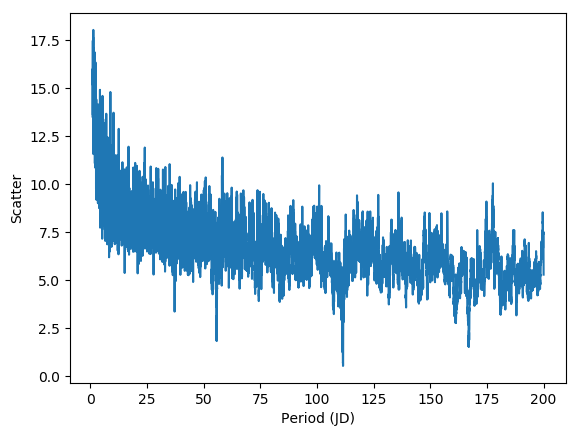

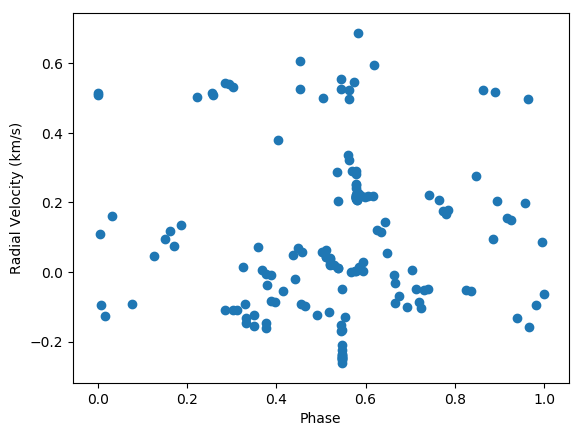

.47594759475948

In [8]:
P_grid = range(1, stop=200, length=10000)
scatters = periodogram(rv_data, time_data, P_grid)

figure()
plot(P_grid, scatters)
xlabel("Period (JD)")
ylabel("Scatter")
show();

best_P = P_grid[sortperm(scatters)[1]]

plot_periodogram(best_P)

print("Minimum scatter at P = ")
print(best_P)

# Optimize over orbital parameters

$ M = \frac{2\pi}{P}(t - t_p) $

`E = newton_method(M, e)`

$ f = 2 \mathrm{arctan}[(\frac{1+e}{1-e})^{1/2} \mathrm{tan}(\frac{E}{2})] $

In [9]:
function model_rv(h, c, v0, f)
   return h .* cos.(f) .+ c .* sin.(f) .+ v0 
end;

In [10]:
function chi_sq(rv_data, rv_err, model_rvs)
    return sum((rv_data .- model_rvs).^2 ./ rv_err.^2)
end;

In [11]:
function dgdE(E, e)
    return 1 - e*cos(E)
end;

In [12]:
function g(E, e, M)
    return E - e*sin(E) - M
end;

In [13]:
# Check the convergence criterion of the kepler solver
function check_convergence(conv_arr)
    for a in conv_arr
        if a > 1E-9
           return false 
        end
    end
    return true
end

# Compute E for given M and e
function kepler_solver(M, e)
    E0 = M + 0.85 * e * sign.(sin.(M))
    g0 = g.(E0, e, M)
    dgdE0 = dgdE.(E0, e)
    converged = false
    i = 0
    while !converged
        E = E0 - g.(E0, e, M) ./ dgdE.(E0, e)
        E0 = E
        converged = check_convergence(abs.(-g.(E0, e, M) ./ dgdE.(E0, e)))
        i = i + 1
        if i > 100
            return E0
        end
    end
    return E0
end;

In [14]:
# Compute f from e and E
function f(e, E)
    return 2*atan.( ((1 + e) / (1 - e))^2 * tan.(E/2))
end;

In [15]:
# Compute M from P, t, t_p, where t are the times associated with RV measurements
function M(P, t, t_p)
    return 2 * pi / P * (t .- t_p)
end;

# steps:

1) given: P, e, t_p: optimize for these vals

2) solve for M over all measurements:

$ M = \frac{2\pi}{P} ( t - t_p ) $

3) Solve for E over all measurements

$ M = E - e \sin(E) $

`E = newton(M, e)`

4) Solve for f over all measurements

$ f = 2 \tan^{-1} ( ( \frac{1 + e}{1 - e} )^{1/2} \tan(E / 2) ) $

5) Solve analytically for $h$, $c$, $v_0$ that minimize $\chi^2$

The following code implements the procedure outlined by [Wright & Howard (2009)](https://iopscience.iop.org/article/10.1088/0067-0049/182/1/205/pdf).

In [16]:
# Compute W given the uncertainties on the RV measurements
# W = \delta_ij sigma_i^2
# Where sigma_i is the RV uncertainty
function init_W(rv_errs)
    return Diagonal(1 ./ rv_errs.^2)
end;

In [17]:
# Compute F, the matrix containing coefficents of the linear parameters
function init_F(f)
    N = size(f)[1]
    cos_f = cos.(f)
    sin_f = sin.(f)
    ones_f = ones(N)
    
    F = transpose(hcat(cos_f, sin_f, ones_f))
    return F
end;

In [18]:
# Compute epsilon, the variance-covariance matrix given F and W
function compute_eps(F, W)
    N = size(F)[1]
    little_bit_of_identity = 1E-9 .* Diagonal(ones(N))
    eps = inv(F * W * transpose(F) + little_bit_of_identity)
    return eps
end;

In [19]:
# Compute the values of the linear paramters given F, W, epsilon, and the RV measurements
function compute_beta(F, W, eps, rv_data)
    beta = reshape(rv_data, (1, size(rv_data)[1])) * W * transpose(F) * eps
    return beta
end;

In [20]:
# For given P, e, t_p and RV measurements, associated times and errors, compute the values of
# h, c, and v_0 which minimize the chi-squared between Keplerian model and measured RVs
function optim_h_c_v0(P, e, t_p, rv_data, time_data, rv_err)
    M_vals = M(P, time_data, t_p)
    E_vals = kepler_solver(M_vals, e)
    f_vals = f(e, E_vals)

    W = init_W(rv_err)
    F = init_F(f_vals)
    eps = compute_eps(F, W)
    beta = compute_beta(F, W, eps, rv_data)
    
    h, c, v0 = beta[1], beta[2], beta[3]
    
    chi_squared = chi_sq(rv_data, rv_err, model_rv(h, c, v0, f_vals))
    
    return h, c, v0, chi_squared
end;

In [21]:
# Function to use with the Optim package to optimize over the non-linear parameters
# P, e, and t_p
function optim_P_e_t_p(x)
    P, e, t_p = x[1], x[2], x[3]
    # Perform bounds checking
    if P < 0 || t_p < 0 || e < 0 || e > 1
        return 1E14
    end
    h, c, v0, chi_squared = optim_h_c_v0(P, e, t_p, rv_data, time_data, rv_err)
    return chi_squared
end;

Non-linear optimization over $P$, $e$, and $t_p$

In [22]:
function compute_gamma(h, v0, e)
   return v0 - e * h 
end;

function compute_K(h, c)
   return sqrt(h^2 + c^2) 
end;

function compute_omega(h, K)
    return acos(h / K)
end;

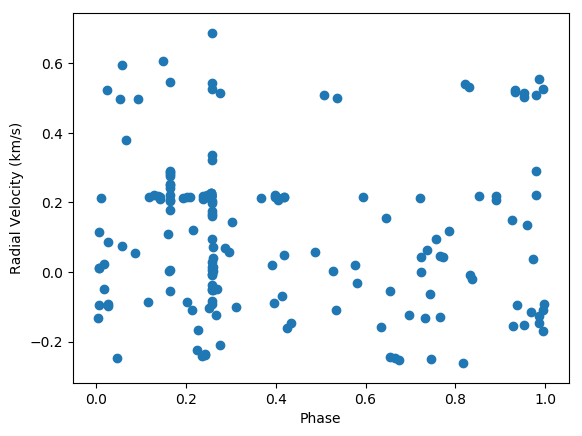

P = 103.30120834831952
e = 0.5095033147602173
t_p = 2.0230052931852556
gamma = 0.15655512441618405
K = 0.3932866421457521
omega = 1.4645591637812942
Chi-Squared = 77936.95343652694


In [23]:
res = optimize(optim_P_e_t_p, [111, 0.2, 1])
Optim.summary(res)

min_res = Optim.minimizer(res)
P, e, t_p = min_res[1], min_res[2], min_res[3]
h, c, v0, chi_squared = optim_h_c_v0(P, e, t_p, rv_data, time_data, rv_err)

plot_periodogram(P)

gam = compute_gamma(h, v0, e)
kam = compute_K(h, c)
wam = compute_omega(h, kam)

print("P = ", P, "\n")
print("e = ", e, "\n") 
print("t_p = ", t_p, "\n")
print("gamma = ", gam, "\n")
print("K = ", kam, "\n")
print("omega = ", wam, "\n")
print("Chi-Squared = ", chi_squared, "\n")